# **Creating an Autoencoder**

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle, gzip, math, os, time, shutil
import fastcore.all as fc
from operator import attrgetter, itemgetter
from functools import partial
from collections.abc import Mapping
from pathlib import Path

import torch
from torch import nn, tensor, optim
from torch.utils.data import default_collate, DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder

from miniai.training import * # Modules have already been developed in previous NBs
from miniai.datasets import * # and, reside in separate Github repo.
from miniai.conv import *
from fastprogress import progress_bar, master_bar

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=14, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging 
logging.disable(logging.WARNING)

## **Load Hugging Face Fashion MNIST Data**

Building on what we worked on in [NB 06_datasets](https://github.com/bachaudhry/FastAI-22-23/blob/main/course_part_2/06_datasets.ipynb), it is time to build models using the HuggingFace Fashion MNIST dataset.

In [3]:
name  = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description) # This provides handy meta data for the dataset.

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [4]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [5]:
ds_builder.info.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [6]:
# Preset image and label
x, y = 'image', 'label'
dsd = load_dataset(name)
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

We need to convert each image into a tensor, so let's run the transformation using the `@inplace` decorator.

In [7]:
# Using our decorator from the same NB
@inplace
def transform_i(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [8]:
# Set Batch size and run transformation inplace
bs = 256
tds = dsd.with_transform(transform_i)

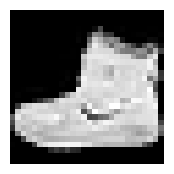

In [9]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(2,2));

In [10]:
# Collate func
# Take in a batch of data and put the elements within the batch into a tensor with an additional outer dimension - batch size
cf = collate_dict(ds)

In [11]:
# Using the collate function with the to_device() function from nb-07
def collate_(b): return to_device(cf(b))
# Create the Dataloader function, which goes through each item in the dataset dict(dsd) and 
# creates a dict of dataloaders
# num workers added after slow CNN performance
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs,**kwargs) for k, v in dsd.items()}

In [12]:
dls = data_loaders(tds, bs, collate_fn=collate_)
dls

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fa8f08eba90>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fa8f08ebf70>}

In [13]:
# Dataloaders for training and validation
dt = dls['train']
dv = dls['test']
# Grab x and y batches
xb, yb = next(iter(dt))

In [14]:
# Get names for the features
labels = ds.features[y].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [15]:
# Make a label getter and grab a minibatch of 16 imgs
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

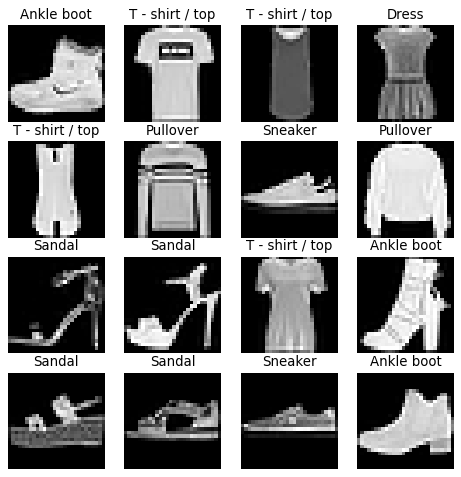

In [16]:
# View minibatch samples with labels
mpl.rcParams['figure.dpi'] = 80
show_images(xb[:16], imsize=1.8, titles=titles);

## **Create a Simple CNN Classifier**

In [17]:
bs = 256
lr = 0.4

In [18]:
# Setup NN using the conv() function from nb07 with 3x3 ks and stride-2
cnn = nn.Sequential(
    conv(1, 4),              #14x14
    conv(4, 8),              #7x7
    conv(8, 16),             #4x4
    conv(16, 16),            #2x2
    conv(16, 10, act=False), #1x1
    nn.Flatten()
).to(def_device)

In [19]:
opt = optim.SGD(cnn.parameters(), lr=lr)

%time loss, acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.781072154045105 0.7108
1 0.5751161855220794 0.7923
2 0.5067703869342804 0.8187
3 0.4936272106647491 0.8239
4 0.47966703510284425 0.8321
CPU times: user 23.6 s, sys: 288 ms, total: 23.9 s
Wall time: 24.2 s


In [20]:
# Grabbing a single training sample
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

The sequential model is pretty slowly, especially when compared to the standard MNIST dataset used in NB-07. And the accuracy is pretty low, compared to the leaderboard on the [papers with code](https://paperswithcode.com/sota/image-classification-on-fashion-mnist) site.

Sticking to the issue of speed, the reason for the slower performance is due to fact the MNIST was loaded onto the GPU memory as a single, large tensor block. But the HuggingFace training set consists of separate PNG images, which aren't pre-converted into a single format. So the dataloader has to spend extra time decoding the images, which is very CPU intensive, as so is a bottle-neck.

Adding the `num_workers`argument, set to a higher value, also throws an error due to the way the collate function works. So, in short we would have to rewrite the `fit()` function to handle these extra wrinkles.